In [1]:
# pip install pandas numpy matplotlib seaborn scikit-learn pgeocode openpyxl

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression

import pgeocode
from math import radians, sin, cos, sqrt, atan2

import warnings
warnings.filterwarnings("ignore")


In [2]:
path = '/Users/tanjinamoon/Desktop/Capstone Project/Capstone_data'

con_clock_activities     = pd.read_csv(f"{path}/con_clock_activities.csv")
con_custom_fields        = pd.read_csv(f"{path}/con_custom_fields.csv")
con_policy_types         = pd.read_csv(f"{path}/con_policy_types.csv")
con_smart_groups         = pd.read_csv(f"{path}/con_smart_groups.csv")
con_users                = pd.read_csv(f"{path}/con_users.csv")
departments              = pd.read_csv(f"{path}/departments.csv")
employee_model           = pd.read_csv(f"{path}/employee_model.csv")
employees                = pd.read_csv(f"{path}/employees.csv")
timeoff_join             = pd.read_csv(f"{path}/EmployeesWithTimeOffJoin.csv")
his_timecard             = pd.read_csv(f"{path}/his_timecard.csv")
timecard_group           = pd.read_csv(f"{path}/timecard_group.csv")
timecards                = pd.read_csv(f"{path}/timecards.csv")
trades                   = pd.read_csv(f"{path}/trades.csv")
minorities               = pd.read_csv(f"{path}/minorities.csv")
vw_Employees             = pd.read_csv(f"{path}/vw_Employees.csv")
vw_TimeOff               = pd.read_csv(f"{path}/vw_TimeOff.csv")
vw_Users                 = pd.read_csv(f"{path}/vw_Users.csv")

hr_tables = pd.read_excel(f"{path}/HR Tables.xlsx")


In [6]:
print("con_clock_activities:", list(con_clock_activities.columns))
print("con_custom_fields:", list(con_custom_fields.columns))
print("con_policy_types:", list(con_policy_types.columns))
print("con_smart_groups:", list(con_smart_groups.columns))
print("con_users:", list(con_users.columns))

print("departments:", list(departments.columns))
print("employee_model:", list(employee_model.columns))
print("employees:", list(employees.columns))
print("timeoff_join (EmployeesWithTimeOffJoin):", list(timeoff_join.columns))

print("his_timecard:", list(his_timecard.columns))
print("timecard_group:", list(timecard_group.columns))
print("timecards:", list(timecards.columns))
print("trades:", list(trades.columns))
print("minorities:", list(minorities.columns))

print("vw_Employees:", list(vw_Employees.columns))
print("vw_TimeOff:", list(vw_TimeOff.columns))
print("vw_Users:", list(vw_Users.columns))

print("hr_tables:", list(hr_tables.columns))


con_clock_activities: ['RequestId', 'UserId', 'TimeOffs', 'TimeOffsId', 'TimeOffStartTime', 'StartTimeZone', 'TimeOffEndTime', 'EndTimeZone', 'PolicyTypeId', 'DurationValue', 'DurationUnits', 'IsAllDay', 'EmployeeNote', 'TimeOffMamnagerNote', 'CreatedAt', 'ModifiedAt']
con_custom_fields: ['RequestId', 'Name', 'IsRequired', 'CategoryId', 'IsAdminVisible', 'IsAdminEditable', 'IsUserVisible', 'IsUserEditable', 'FieldId', 'FieldType', 'PagingOffset', 'IsMultiSelected', 'DropdownId', 'DropdownOption', 'DropdownDisabled', 'DropdownDeleted']
con_policy_types: ['RequestId', 'TypeId', 'TypeName']
con_smart_groups: ['RequestId', 'GroupId', 'GroupName', 'NumberUsers']
con_users: ['RequestId', 'FirstName', 'UserType', 'FieldId', 'FieldValue', 'FieldType', 'FieldName', 'IsArchived', 'UserId', 'KioskId', 'SmartGroupId', 'InvitedManager', 'PagingOffset', 'ValueId', 'ValueValue', 'CreatedAt', 'ModifiedAt', 'LastLogin']
departments: ['client_id', 'system_id', 'company_no', 'dept_no', 'description', 'gl

In [7]:
# base copy
emp = employees.copy()

# dates (just to be sure)
emp["date_of_birth"]   = pd.to_datetime(emp["date_of_birth"], errors="coerce")
emp["date_hired"]      = pd.to_datetime(emp["date_hired"], errors="coerce")
emp["date_terminated"] = pd.to_datetime(emp["date_terminated"], errors="coerce")

# make sure pay_rate, age, tenure are numeric
emp["pay_rate"] = pd.to_numeric(emp["pay_rate"], errors="coerce")
emp["age"]      = pd.to_numeric(emp.get("age"), errors="coerce")
emp["tenure"]   = pd.to_numeric(emp.get("tenure"), errors="coerce")

# if age is missing but DOB exists, calculate age
today = pd.Timestamp.today().normalize()
mask_age = emp["age"].isna() & emp["date_of_birth"].notna()
emp.loc[mask_age, "age"] = (today - emp.loc[mask_age, "date_of_birth"]).dt.days / 365.25

# if tenure is missing but hire date exists, calculate tenure
mask_tenure = emp["tenure"].isna() & emp["date_hired"].notna()
emp.loc[mask_tenure, "tenure"] = (today - emp.loc[mask_tenure, "date_hired"]).dt.days / 365.25

# termination flag if not already set
if "terminated_flag" not in emp.columns:
    emp["terminated_flag"] = emp["date_terminated"].notna()

# add trade description
trades_simple = trades[["trade_no", "description"]].rename(columns={"description": "trade_desc"})
emp = emp.merge(trades_simple, on="trade_no", how="left")

# add department description
depts_simple = departments[["dept_no", "description"]].rename(columns={"description": "dept_desc"})
emp = emp.merge(depts_simple, on="dept_no", how="left")

# add minority description (keep nulls as null, no dropping)
minority_simple = minorities[["minority_no", "description"]].rename(columns={"description": "minority_desc"})
emp = emp.merge(minority_simple, on="minority_no", how="left")

# keep a slimmer version as main employee table
emp_main = emp[[
    "employee_no",
    "employee_id",
    "sex",
    "city",
    "state",
    "zip_code",
    "date_of_birth",
    "age",
    "date_hired",
    "tenure",
    "date_terminated",
    "terminated_flag",
    "termination_reason",
    "trade_no",
    "trade_desc",
    "dept_no",
    "dept_desc",
    "minority_no",
    "minority_desc",
    "pay_rate"
]].copy()

print(emp_main.head())
print(emp_main.dtypes)


   employee_no  employee_id sex         city state  zip_code date_of_birth  \
0          798          798   M    Rochester    NY     14617    1986-04-30   
1           10           10   F      Ontario    NY     14519    1975-04-10   
2           12           12   M  Spencerport    NY     14559    1980-10-23   
3           25           25   M    Dansville    NY     14437    1966-12-17   
4           51           51   M      Webster    NY     14580    1994-06-03   

         age date_hired     tenure date_terminated  terminated_flag  \
0  39.589322 2025-09-12   0.219028             NaT            False   
1  50.644764 2006-01-01  19.915127             NaT            False   
2  45.106092 2007-06-18  18.455852             NaT            False   
3  58.956879 2009-03-25  16.687201             NaT            False   
4  31.496235 2010-10-18  15.121150             NaT            False   

  termination_reason trade_no trade_desc dept_no   dept_desc minority_no  \
0                NaN    LAB 

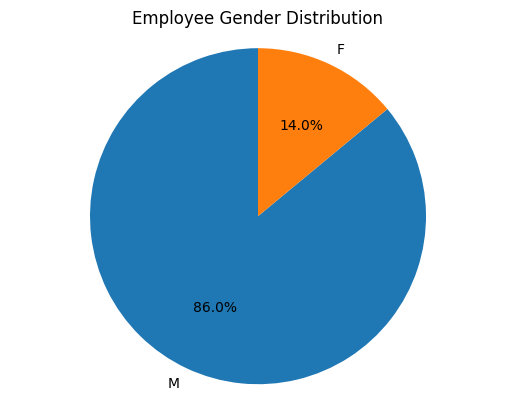

In [8]:
# Pie chart of male vs female employees
gender_counts = emp_main["sex"].value_counts(dropna=False)

labels = gender_counts.index.astype(str)
sizes  = gender_counts.values

plt.figure()
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Employee Gender Distribution")
plt.axis("equal")
plt.show()


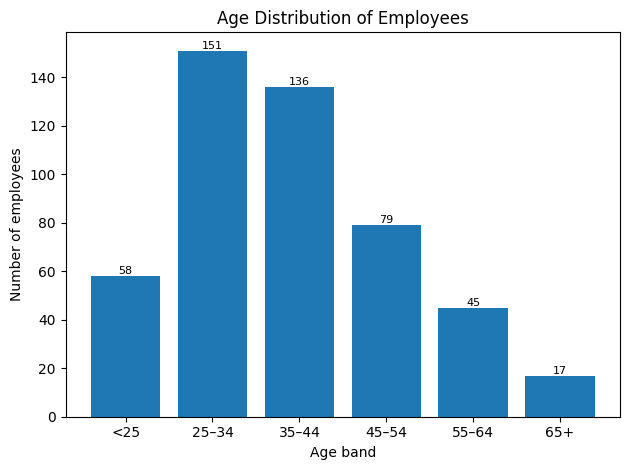

In [12]:
# Age distribution in bands

age_data = emp_main["age"].dropna()

bins = [0, 25, 35, 45, 55, 65, 200]
labels = ["<25", "25–34", "35–44", "45–54", "55–64", "65+"]

age_band = pd.cut(age_data, bins=bins, labels=labels, right=False)
age_counts = age_band.value_counts().reindex(labels)

plt.figure()
ax = plt.bar(age_counts.index.astype(str), age_counts.values)
plt.title("Age Distribution of Employees")
plt.xlabel("Age band")
plt.ylabel("Number of employees")

for i, v in enumerate(age_counts.values):
    plt.text(i, v, str(int(v)), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


In [17]:
# ---------------------------------------------------------------------
# Field vs admin flag 
# ---------------------------------------------------------------------

field_depts = ["CONST", "SUPER", "FIELD"]   # update if needed
admin_depts = ["ADMIN", "OFFICE"]           # update if needed

def classify_emp_type(d):
    d = str(d)
    if d in field_depts:
        return "Field"
    if d in admin_depts:
        return "Admin"
    return "Unknown"

employees["emp_type"] = employees["dept_no"].apply(classify_emp_type)
employees_clean = employees[employees["emp_type"].isin(["Field", "Admin"])].copy()

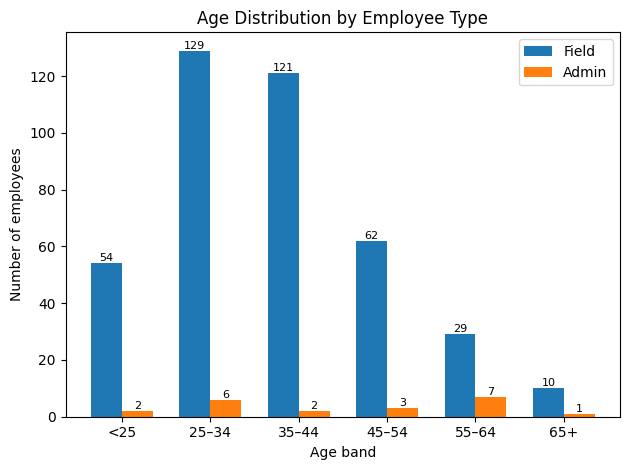

In [18]:
# make sure age_years exists
if "age_years" not in employees_clean.columns:
    employees_clean["date_of_birth"] = pd.to_datetime(employees_clean["date_of_birth"], errors="coerce")
    today = pd.Timestamp.today().normalize()
    employees_clean["age_years"] = (today - employees_clean["date_of_birth"]).dt.days / 365.25

# keep only Field/Admin with non-missing age
df = employees_clean[
    employees_clean["emp_type"].isin(["Field", "Admin"])
].dropna(subset=["age_years"]).copy()

bins   = [0, 25, 35, 45, 55, 65, 200]
labels = ["<25", "25–34", "35–44", "45–54", "55–64", "65+"]

df["age_band"] = pd.cut(df["age_years"], bins=bins, labels=labels, right=False)

age_tab = df.groupby(["age_band", "emp_type"]).size().unstack(fill_value=0)
age_tab = age_tab.reindex(labels)
age_tab = age_tab.reindex(columns=["Field", "Admin"], fill_value=0)

x = np.arange(len(age_tab))
width = 0.35

plt.figure()
field_vals = age_tab["Field"].values
admin_vals = age_tab["Admin"].values

plt.bar(x - width/2, field_vals, width, label="Field")
plt.bar(x + width/2, admin_vals, width, label="Admin")

plt.title("Age Distribution by Employee Type")
plt.xlabel("Age band")
plt.ylabel("Number of employees")
plt.xticks(x, age_tab.index)

for i, v in enumerate(field_vals):
    if v > 0:
        plt.text(x[i] - width/2, v, str(int(v)), ha="center", va="bottom", fontsize=8)
for i, v in enumerate(admin_vals):
    if v > 0:
        plt.text(x[i] + width/2, v, str(int(v)), ha="center", va="bottom", fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()


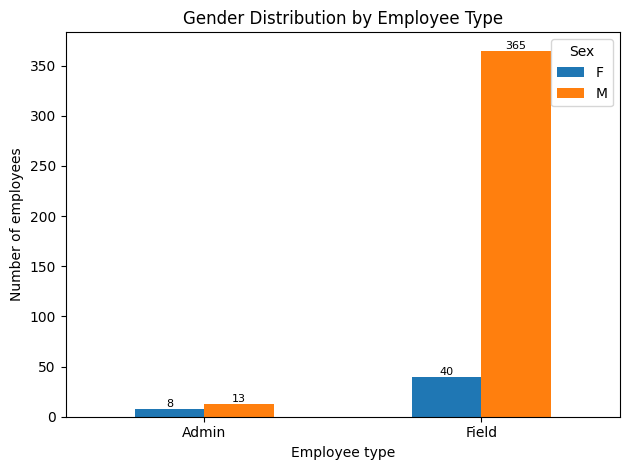

In [19]:
# Gender distribution in Field and Admin

df = employees_clean[
    employees_clean["emp_type"].isin(["Field", "Admin"])
].copy()

gender_tab = df.groupby(["emp_type", "sex"]).size().unstack(fill_value=0)

ax = gender_tab.plot(kind="bar")
plt.title("Gender Distribution by Employee Type")
plt.xlabel("Employee type")
plt.ylabel("Number of employees")
plt.xticks(rotation=0)
plt.legend(title="Sex")

for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(
            str(int(h)),
            (p.get_x() + p.get_width() / 2, h),
            ha="center",
            va="bottom",
            fontsize=8
        )

plt.tight_layout()
plt.show()


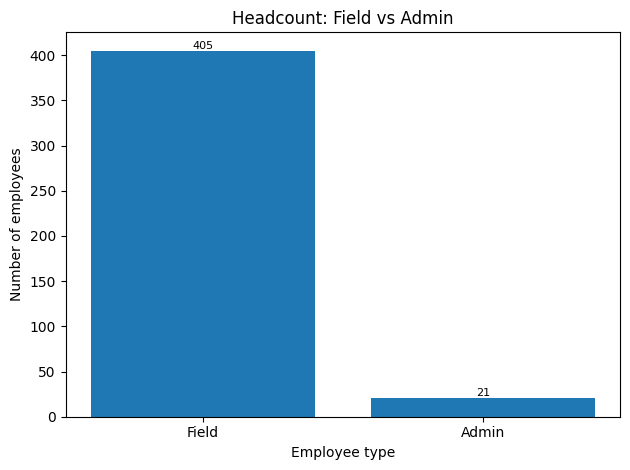

In [21]:
# Admin vs Field headcount

df = employees_clean[employees_clean["emp_type"].isin(["Field", "Admin"])]

counts = df["emp_type"].value_counts().reindex(["Field", "Admin"])

plt.figure()
ax = plt.bar(counts.index, counts.values)
plt.title("Headcount: Field vs Admin")
plt.xlabel("Employee type")
plt.ylabel("Number of employees")

for i, v in enumerate(counts.values):
    plt.text(i, v, str(int(v)), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


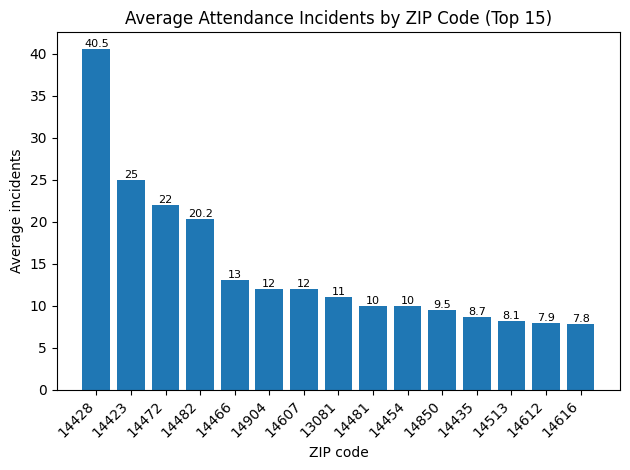

In [24]:
# Average attendance incidents by ZIP (top 15)

df = employee_model.copy()
df["IncidentCount"] = pd.to_numeric(df["IncidentCount"], errors="coerce")

df = df.merge(
    vw_Employees[["EmployeeID", "FirstName"]],
    on="EmployeeID",
    how="left"
)

df = df.dropna(subset=["HomeZip", "IncidentCount"])

zip_avg = (
    df.groupby("HomeZip")["IncidentCount"]
      .mean()
      .sort_values(ascending=False)
      .head(15)
)

def fmt_zip(z):
    try:
        zf = float(z)
        if zf.is_integer():
            return str(int(zf))
        return str(z)
    except:
        return str(z)

def fmt_num(x):
    x = float(x)
    if x.is_integer():
        return str(int(x))
    return f"{x:.1f}"

zip_labels = [fmt_zip(z) for z in zip_avg.index]
values = zip_avg.values

plt.figure()
bars = plt.bar(zip_labels, values)
plt.title("Average Attendance Incidents by ZIP Code (Top 15)")
plt.xlabel("ZIP code")
plt.ylabel("Average incidents")
plt.xticks(rotation=45, ha="right")

for i, v in enumerate(values):
    plt.text(i, v, fmt_num(v), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


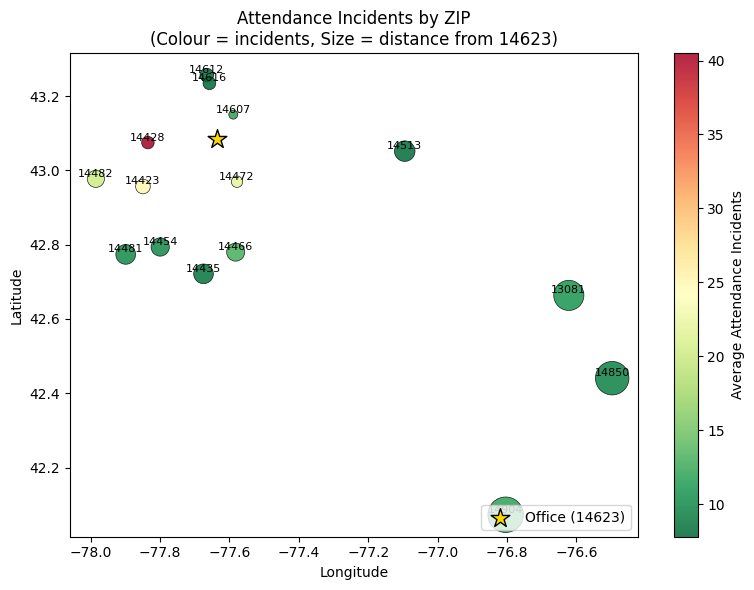

In [27]:
# average incidents by ZIP from employee_model (real values)
df = employee_model.copy()
df["IncidentCount"] = pd.to_numeric(df["IncidentCount"], errors="coerce")
df = df.dropna(subset=["HomeZip", "IncidentCount"])

def clean_zip(z):
    s = str(z)
    if s.endswith(".0"):
        s = s[:-2]
    return s.zfill(5)

zip_avg = (
    df.groupby("HomeZip")["IncidentCount"]
      .mean()
      .sort_values(ascending=False)
      .head(15)
)

zip_list = [clean_zip(z) for z in zip_avg.index]
avg_incidents = zip_avg.values

# office ZIP
office_zip = "14623"

nomi = pgeocode.Nominatim("us")
geo = nomi.query_postal_code(zip_list)
office_geo = nomi.query_postal_code(office_zip)

def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

geo["distance_miles"] = geo.apply(
    lambda r: haversine(office_geo.latitude, office_geo.longitude, r.latitude, r.longitude),
    axis=1
)
geo["avg_incidents"] = avg_incidents

# drop any rows missing coords
geo = geo.dropna(subset=["latitude", "longitude", "distance_miles"])

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    geo["longitude"],
    geo["latitude"],
    c=geo["avg_incidents"],
    s=geo["distance_miles"] * 8,
    cmap="RdYlGn_r",
    alpha=0.85,
    edgecolors="black",
    linewidths=0.5
)

plt.scatter(
    office_geo.longitude,
    office_geo.latitude,
    marker="*",
    color="gold",
    s=200,
    edgecolors="black",
    label=f"Office ({office_zip})"
)

for _, row in geo.iterrows():
    plt.text(row["longitude"], row["latitude"], str(row["postal_code"]), fontsize=8,
             ha="center", va="bottom")

cbar = plt.colorbar(sc)
cbar.set_label("Average Attendance Incidents")

plt.title("Attendance Incidents by ZIP\n(Colour = incidents, Size = distance from 14623)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


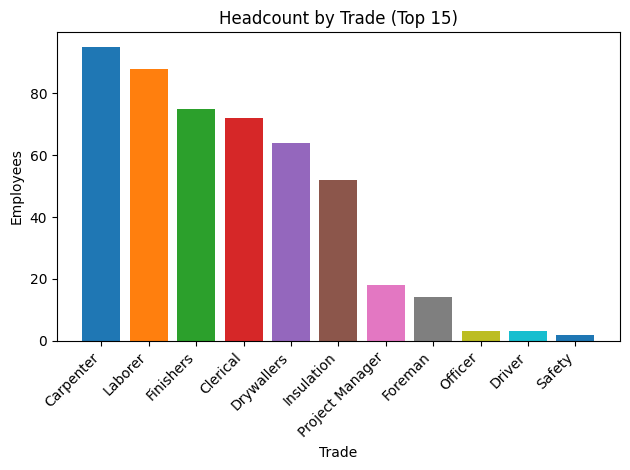

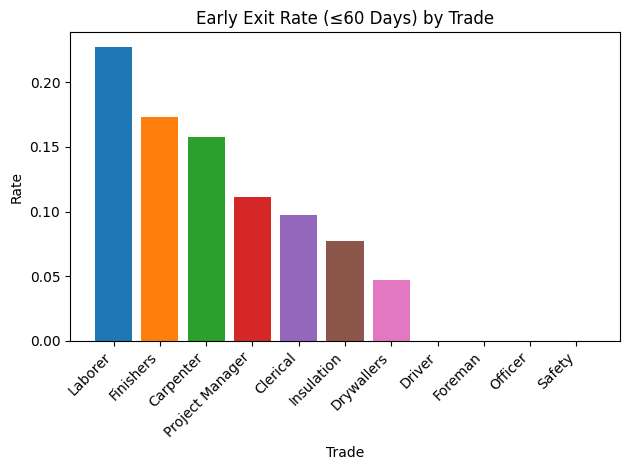

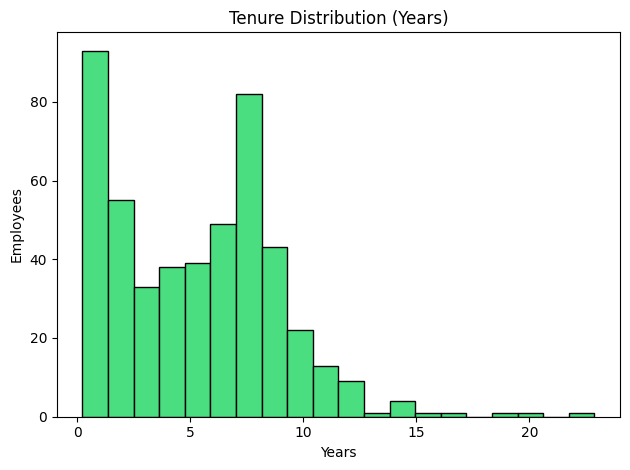

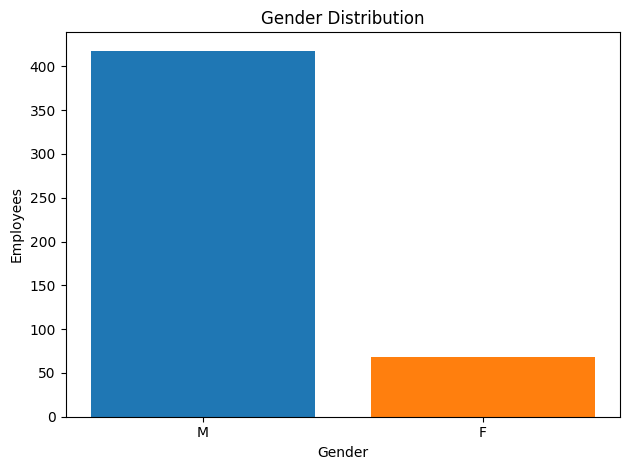

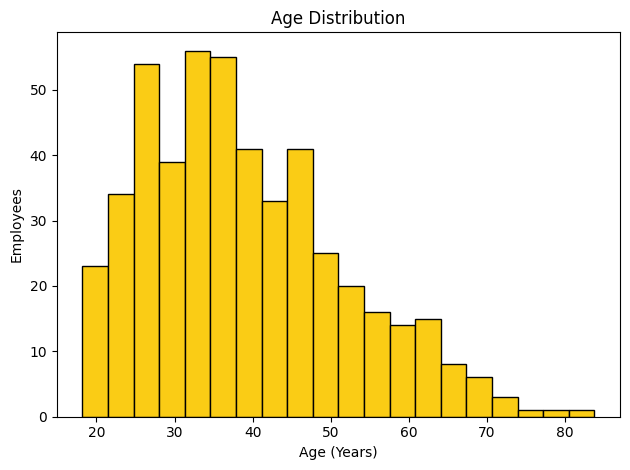

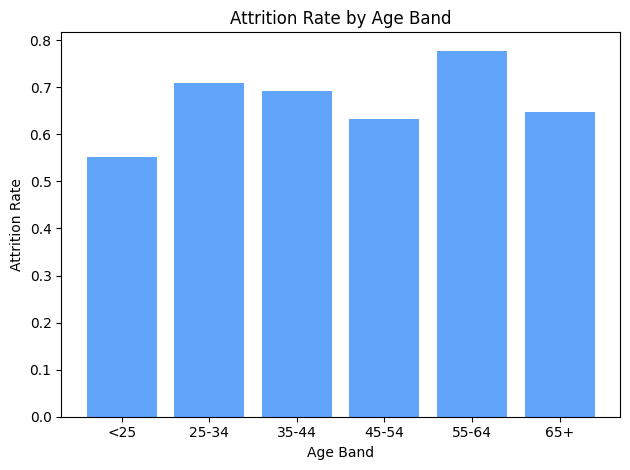

In [29]:
# Regenerate all the main graphs using multiple colors for variety and clarity.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Helper to make color palettes
def color_cycle(n):
    cmap = plt.get_cmap("tab10")
    return [cmap(i % 10) for i in range(n)]

# 1. Headcount by Trade
emp = pd.read_csv("/Users/tanjinamoon/Desktop/Capstone Project/Capstone_data/employees.csv")
trades = pd.read_csv("/Users/tanjinamoon/Desktop/Capstone Project/Capstone_data/trades.csv")

emp_tr = emp.merge(trades[["trade_no", "description"]], on="trade_no", how="left")
trade_counts = emp_tr["description"].fillna("Unknown").value_counts().head(15)

plt.figure()
plt.bar(trade_counts.index, trade_counts.values, color=color_cycle(len(trade_counts)))
plt.title("Headcount by Trade (Top 15)")
plt.xlabel("Trade")
plt.ylabel("Employees")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 2. Early Exit Rate (≤60 days) by Trade
emp["date_hired"] = pd.to_datetime(emp["date_hired"], errors="coerce")
emp["date_terminated"] = pd.to_datetime(emp["date_terminated"], errors="coerce")
emp["terminated_flag"] = emp["date_terminated"].notna()
emp["early_exit_60"] = emp["terminated_flag"] & ((emp["date_terminated"] - emp["date_hired"]).dt.days <= 60)

emp_tr = emp.merge(trades[["trade_no", "description"]], on="trade_no", how="left")
early = emp_tr.groupby("description").agg(headcount=("employee_no","nunique"),
                                          early_exits=("early_exit_60","sum"))
early["rate"] = early["early_exits"] / early["headcount"]
early = early.sort_values("rate", ascending=False).head(15)

plt.figure()
plt.bar(early.index, early["rate"], color=color_cycle(len(early)))
plt.title("Early Exit Rate (≤60 Days) by Trade")
plt.xlabel("Trade")
plt.ylabel("Rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3. Tenure Distribution (Years)
emp["tenure"] = (pd.Timestamp.today() - pd.to_datetime(emp["date_hired"], errors="coerce")).dt.days / 365.25
plt.figure()
plt.hist(emp["tenure"].dropna(), bins=20, color="#4ADE80", edgecolor="black")
plt.title("Tenure Distribution (Years)")
plt.xlabel("Years")
plt.ylabel("Employees")
plt.tight_layout()
plt.show()

# 4. Gender Distribution
if "sex" in emp.columns:
    g_counts = emp["sex"].fillna("Unknown").value_counts()
    plt.figure()
    plt.bar(g_counts.index, g_counts.values, color=color_cycle(len(g_counts)))
    plt.title("Gender Distribution")
    plt.xlabel("Gender")
    plt.ylabel("Employees")
    plt.tight_layout()
    plt.show()

# 5. Age Distribution
emp["date_of_birth"] = pd.to_datetime(emp["date_of_birth"], errors="coerce")
emp["age"] = (pd.Timestamp.today() - emp["date_of_birth"]).dt.days / 365.25
plt.figure()
plt.hist(emp["age"].dropna(), bins=20, color="#FACC15", edgecolor="black")
plt.title("Age Distribution")
plt.xlabel("Age (Years)")
plt.ylabel("Employees")
plt.tight_layout()
plt.show()

# 6. Attrition Rate by Age Band
bins = [0,25,35,45,55,65,120]
labels = ['<25','25-34','35-44','45-54','55-64','65+']
emp["age_band"] = pd.cut(emp["age"], bins=bins, labels=labels, right=False)
band = emp.groupby("age_band").agg(headcount=("employee_no","nunique"),
                                   terminations=("terminated_flag","sum"))
band["attrition_rate"] = band["terminations"] / band["headcount"]
plt.figure()
plt.bar(band.index.astype(str), band["attrition_rate"], color="#60A5FA")
plt.title("Attrition Rate by Age Band")
plt.xlabel("Age Band")
plt.ylabel("Attrition Rate")
plt.tight_layout()
plt.show()


In [30]:
# 7. Time-Off Requests by Month
to = pd.read_csv("/Users/tanjinamoon/Desktop/Capstone Project/Capstone_data/EmployeesWithTimeOffJoin.csv")
to["TimeOffStartTime"] = pd.to_datetime(to["TimeOffStartTime"], errors="coerce")
month_counts = to.groupby(to["TimeOffStartTime"].dt.to_period("M")).size().sort_index()

plt.figure()
plt.plot([str(p) for p in month_counts.index], month_counts.values, marker="o", color="#8B5CF6")
plt.title("Time-Off Requests by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 8. Total Hours Worked by Month
tc = pd.read_csv("/Users/tanjinamoon/Desktop/Capstone Project/Capstone_data/timecards.csv")
tc["dated"] = pd.to_datetime(tc["dated"], errors="coerce")
tc["hours"] = pd.to_numeric(tc["hours"], errors="coerce")
bym = tc.groupby(tc["dated"].dt.to_period("M"))["hours"].sum().sort_index()

plt.figure()
plt.plot([str(p) for p in bym.index], bym.values, marker="o", color="#F97316")
plt.title("Total Hours Worked by Month")
plt.xlabel("Month")
plt.ylabel("Hours")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
# 9. Average Pay Rate by Trade (Top 15)
emp["pay_rate_num"] = pd.to_numeric(emp["pay_rate"], errors="coerce")
avg_pay = emp_tr.groupby("description")["pay_rate_num"].mean().sort_values(ascending=False).head(15)

plt.figure()
plt.bar(avg_pay.index, avg_pay.values, color=color_cycle(len(avg_pay)))
plt.title("Average Pay Rate by Trade (Top 15)")
plt.xlabel("Trade")
plt.ylabel("Average Pay Rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 10. Termination Reason Breakdown
term_reason = emp["termination_reason"].fillna("Unknown").value_counts().head(10)
plt.figure()
plt.barh(term_reason.index, term_reason.values, color=color_cycle(len(term_reason)))
plt.title("Top Termination Reasons")
plt.xlabel("Employees")
plt.ylabel("Reason")
plt.tight_layout()
plt.show()

# 11. Statewise Headcount (if available)
if "state" in emp.columns:
    state_counts = emp["state"].fillna("Unknown").value_counts().head(10)
    plt.figure()
    plt.bar(state_counts.index, state_counts.values, color=color_cycle(len(state_counts)))
    plt.title("Headcount by State (Top 10)")
    plt.xlabel("State")
    plt.ylabel("Employees")
    plt.tight_layout()
    plt.show()

KeyError: 'TimeOffStartTime'

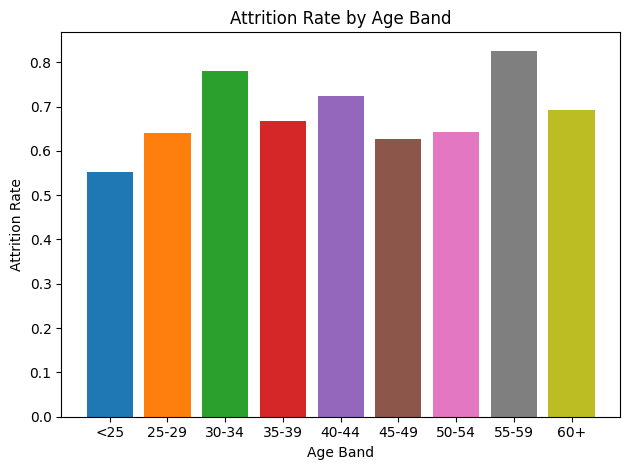

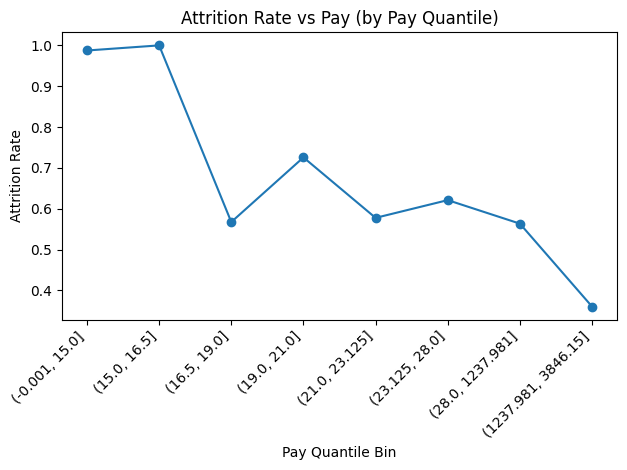

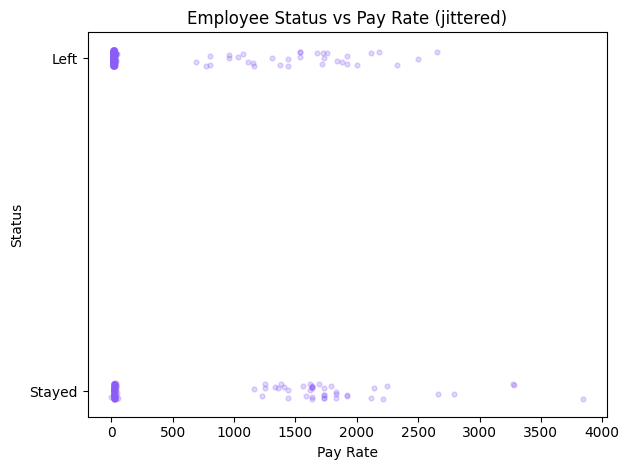

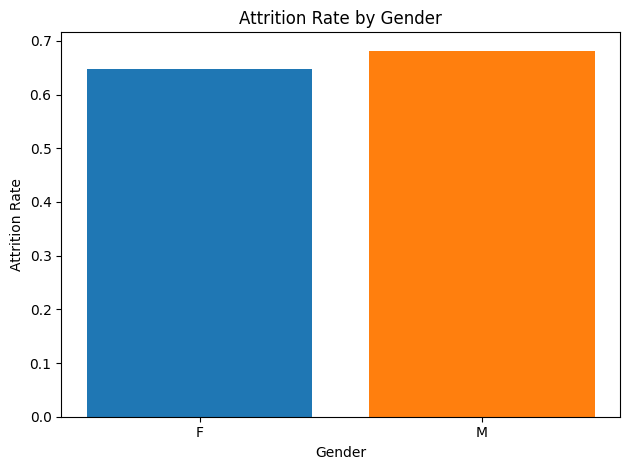

In [33]:

# ---------- Employees prep ----------
emp["date_hired"]      = pd.to_datetime(emp.get("date_hired"), errors="coerce")
emp["date_terminated"] = pd.to_datetime(emp.get("date_terminated"), errors="coerce")
emp["date_of_birth"]   = pd.to_datetime(emp.get("date_of_birth"), errors="coerce")
emp["terminated_flag"] = emp["date_terminated"].notna()
emp["sex"]             = emp.get("sex")
emp["pay_rate_num"]    = pd.to_numeric(emp.get("pay_rate"), errors="coerce")

today = pd.Timestamp.today().normalize()
emp["age_years"] = (today - emp["date_of_birth"]).dt.days / 365.25

def tab10(n):
    cmap = plt.get_cmap("tab10")
    return [cmap(i % 10) for i in range(n)]

# Attrition Rate by Age Band
bins = [0,25,30,35,40,45,50,55,60,120]
labels = ["<25","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60+"]
emp["age_band"] = pd.cut(emp["age_years"], bins=bins, labels=labels, right=False)
age_attr = emp.groupby("age_band").agg(headcount=("employee_no","nunique"),
                                       terms=("terminated_flag","sum"))
age_attr["attrition_rate"] = (age_attr["terms"] / age_attr["headcount"]).fillna(0)

plt.figure()
plt.bar(age_attr.index.astype(str), age_attr["attrition_rate"], color=tab10(len(age_attr)))
plt.title("Attrition Rate by Age Band")
plt.xlabel("Age Band")
plt.ylabel("Attrition Rate")
plt.tight_layout()
plt.show()

# Attrition vs Pay (quantile bins) + jitter scatter
pay_valid = emp.dropna(subset=["pay_rate_num"])
if not pay_valid.empty:
    pay_valid["pay_bin"] = pd.qcut(pay_valid["pay_rate_num"], q=min(8, pay_valid["pay_rate_num"].nunique()), duplicates="drop")
    pay_attr = pay_valid.groupby("pay_bin").agg(headcount=("employee_no","nunique"),
                                                terms=("terminated_flag","sum"))
    pay_attr["attrition_rate"] = (pay_attr["terms"] / pay_attr["headcount"]).fillna(0)

    plt.figure()
    plt.plot(pay_attr.index.astype(str), pay_attr["attrition_rate"], marker="o")
    plt.title("Attrition Rate vs Pay (by Pay Quantile)")
    plt.xlabel("Pay Quantile Bin")
    plt.ylabel("Attrition Rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Scatter with jittered y
    y = pay_valid["terminated_flag"].astype(int) + (np.random.rand(len(pay_valid)) - 0.5) * 0.05
    plt.figure()
    plt.scatter(pay_valid["pay_rate_num"], y, alpha=0.25, s=12, c="#8B5CF6")
    plt.yticks([0,1], ["Stayed","Left"])
    plt.title("Employee Status vs Pay Rate (jittered)")
    plt.xlabel("Pay Rate")
    plt.ylabel("Status")
    plt.tight_layout()
    plt.show()

# Attrition Rate by Gender
if "sex" in emp.columns:
    gen_attr = emp.groupby("sex").agg(headcount=("employee_no","nunique"),
                                      terms=("terminated_flag","sum"))
    gen_attr["attrition_rate"] = (gen_attr["terms"] / gen_attr["headcount"]).fillna(0)
    plt.figure()
    plt.bar(gen_attr.index.astype(str), gen_attr["attrition_rate"], color=tab10(len(gen_attr)))
    plt.title("Attrition Rate by Gender")
    plt.xlabel("Gender")
    plt.ylabel("Attrition Rate")
    plt.tight_layout()
    plt.show()


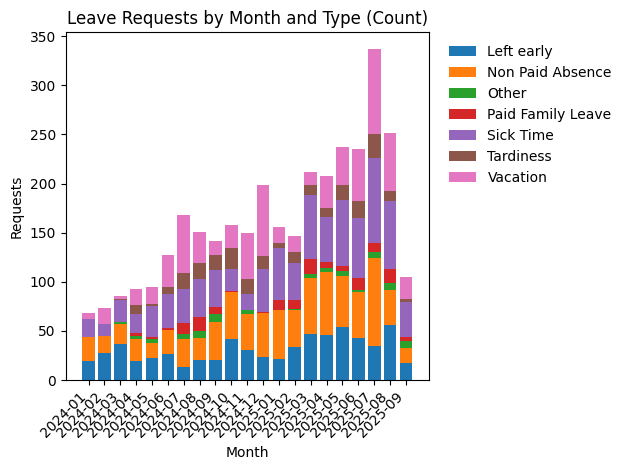

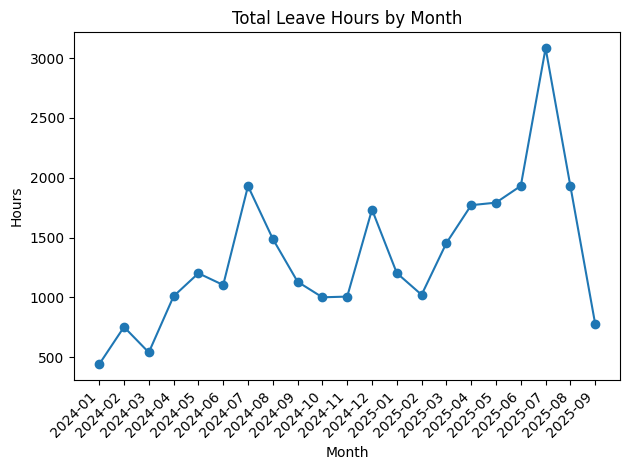

In [40]:
# build a simple time-off table from timeoff_join
to = timeoff_join.copy()
to["TimeOffStartTime"] = pd.to_datetime(to["vw_TimeOff.TimeOffStartTime"], errors="coerce")
to["DurationValue"]    = pd.to_numeric(to["vw_TimeOff.DurationValue"], errors="coerce")
to["TypeName"]         = to["vw_TimeOff.TypeName"]
to["UserId"]           = to["vw_TimeOff.UserId"]

def tab10(n):
    cmap = plt.get_cmap("tab10")
    return [cmap(i % 10) for i in range(n)]

# Leave Requests by Month and Type (stacked bars of top 6 types)
to_valid = to[to["TimeOffStartTime"].notna()].copy()
to_valid["month"] = to_valid["TimeOffStartTime"].dt.to_period("M")

top_types = to_valid["TypeName"].value_counts().head(6).index.tolist()

type_pivot = (
    to_valid
    .assign(TypeTop=to_valid["TypeName"].where(to_valid["TypeName"].isin(top_types), "Other"))
    .pivot_table(
        index="month",
        columns="TypeTop",
        values="UserId",
        aggfunc="count",
        fill_value=0
    )
    .sort_index()
)

plt.figure()
bottom = np.zeros(len(type_pivot))
cols = type_pivot.columns.tolist()
for i, c in enumerate(cols):
    vals = type_pivot[c].values
    plt.bar([str(p) for p in type_pivot.index], vals,
            bottom=bottom, label=str(c), color=tab10(len(cols))[i])
    bottom += vals

plt.title("Leave Requests by Month and Type (Count)")
plt.xlabel("Month")
plt.ylabel("Requests")
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

# Leave Hours by Month (trend)
hours_month = to_valid.groupby("month")["DurationValue"].sum().sort_index()

plt.figure()
plt.plot([str(p) for p in hours_month.index], hours_month.values, marker="o")
plt.title("Total Leave Hours by Month")
plt.xlabel("Month")
plt.ylabel("Hours")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



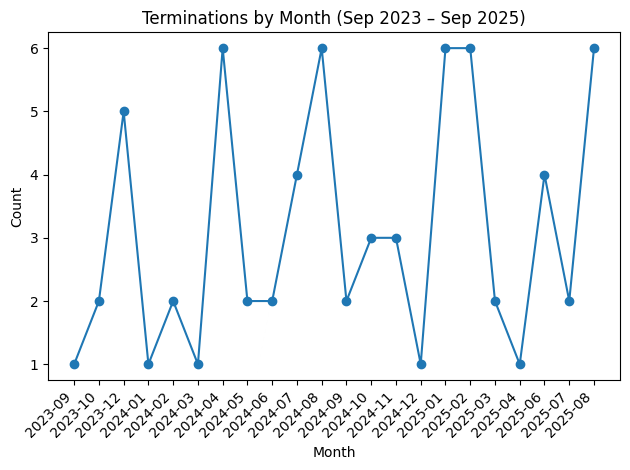

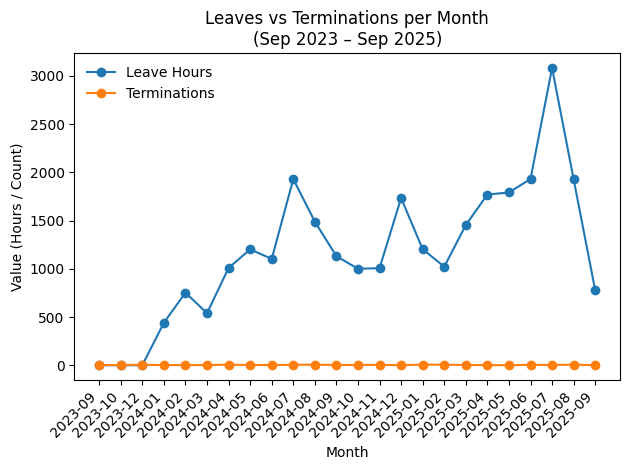

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# time window
start_p = pd.Period('2023-09', freq='M')
end_p   = pd.Period('2025-09', freq='M')

# recompute leave hours by month
to_valid = to[to["TimeOffStartTime"].notna()].copy()
to_valid["month"] = to_valid["TimeOffStartTime"].dt.to_period("M")
hours_month = to_valid.groupby("month")["DurationValue"].sum().sort_index()
hours_month = hours_month[(hours_month.index >= start_p) & (hours_month.index <= end_p)]

# recompute terminations by month
term_month = emp[emp["date_terminated"].notna()].copy()
term_month["tmonth"] = term_month["date_terminated"].dt.to_period("M")
term_counts = term_month.groupby("tmonth").size().sort_index()
term_counts = term_counts[(term_counts.index >= start_p) & (term_counts.index <= end_p)]

# 6) Terminations by month (filtered)
plt.figure()
x_term = [str(p) for p in term_counts.index]
plt.plot(x_term, term_counts.values, marker="o")
plt.title("Terminations by Month (Sep 2023 – Sep 2025)")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 7) Leaves vs terminations per month (filtered)
both = pd.DataFrame({
    "leave_hours": hours_month,
    "terminations": term_counts
}).fillna(0)

plt.figure()
x = [str(p) for p in both.index]
plt.plot(x, both["leave_hours"], marker="o", label="Leave Hours")
plt.plot(x, both["terminations"], marker="o", label="Terminations")
plt.title("Leaves vs Terminations per Month\n(Sep 2023 – Sep 2025)")
plt.xlabel("Month")
plt.ylabel("Value (Hours / Count)")
plt.xticks(rotation=45, ha="right")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [41]:
# ----- prepare data for clustering -----
base = employee_model.copy()

base["Age"]          = pd.to_numeric(base["Age"], errors="coerce")
base["PayRate"]      = pd.to_numeric(base["PayRate"], errors="coerce")
base["IncidentCount"]= pd.to_numeric(base["IncidentCount"], errors="coerce")

# bring in tenure from employees_clean (if you already built it)
# employees_clean should have columns: employee_id, tenure, emp_type
ten = employees_clean[["employee_id", "tenure", "emp_type"]].copy()
ten.rename(columns={"employee_id": "EmployeeID"}, inplace=True)
base = base.merge(ten, on="EmployeeID", how="left")

# simple tenure column
base["Tenure"] = pd.to_numeric(base["tenure"], errors="coerce")

# binary for employee type (Field = 1, Admin = 0)
base["EmpType_Field"] = np.where(base["emp_type"] == "Field", 1,
                          np.where(base["emp_type"] == "Admin", 0, np.nan))

# binary for sex (male = 1, female = 0, others -> NaN)
sex_upper = base["Sex"].astype(str).str.upper()
base["Sex_Male"] = np.where(sex_upper.isin(["M", "MALE"]), 1,
                     np.where(sex_upper.isin(["F", "FEMALE"]), 0, np.nan))

# distance from office zip 14623 using HomeZip
def clean_zip(z):
    s = str(z)
    if s.endswith(".0"):
        s = s[:-2]
    return s.zfill(5)

base["HomeZip_clean"] = base["HomeZip"].dropna().apply(clean_zip)

office_zip = "14623"
nomi = pgeocode.Nominatim("us")
office_geo = nomi.query_postal_code(office_zip)

zip_info = nomi.query_postal_code(base["HomeZip_clean"].dropna().unique().tolist())
zip_info = zip_info[["postal_code", "latitude", "longitude"]].dropna()
zip_info["postal_code"] = zip_info["postal_code"].astype(str)

def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# build distance lookup for each zip
zip_info["DistanceMiles"] = zip_info.apply(
    lambda r: haversine(office_geo.latitude, office_geo.longitude, r.latitude, r.longitude),
    axis=1
)

base = base.merge(
    zip_info[["postal_code", "DistanceMiles"]],
    left_on="HomeZip_clean",
    right_on="postal_code",
    how="left"
)

# ----- select features and drop rows with missing values -----
features = ["Age", "PayRate", "IncidentCount", "Tenure",
            "EmpType_Field", "Sex_Male", "DistanceMiles"]

X = base[features].dropna().copy()

# keep index to assign cluster labels back
idx = X.index

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----- K-means clustering -----
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)

base["cluster3"] = np.nan
base.loc[idx, "cluster3"] = labels.astype(int)

# ----- simple summaries -----
cluster_sizes = base["cluster3"].value_counts().sort_index()
print("Cluster sizes:")
print(cluster_sizes)

cluster_means = base.groupby("cluster3")[features].mean().round(2)
print("\nCluster feature means:")
print(cluster_means)

print("\nCluster by EmployeeType:")
print(pd.crosstab(base["cluster3"], base["emp_type"]))


Cluster sizes:
cluster3
0.0    183
1.0     22
2.0    217
Name: count, dtype: int64

Cluster feature means:
            Age  PayRate  IncidentCount  Tenure  EmpType_Field  Sex_Male  \
cluster3                                                                   
0.0       29.70    20.44           7.45    2.51           1.00      0.79   
1.0       43.95    25.34           0.00    7.41           0.05      0.64   
2.0       43.86    22.92           1.30    7.68           1.00      1.00   

          DistanceMiles  
cluster3                 
0.0               16.15  
1.0              116.60  
2.0               20.31  

Cluster by EmployeeType:
emp_type  Admin  Field
cluster3              
0.0           0    183
1.0          21      1
2.0           0    217


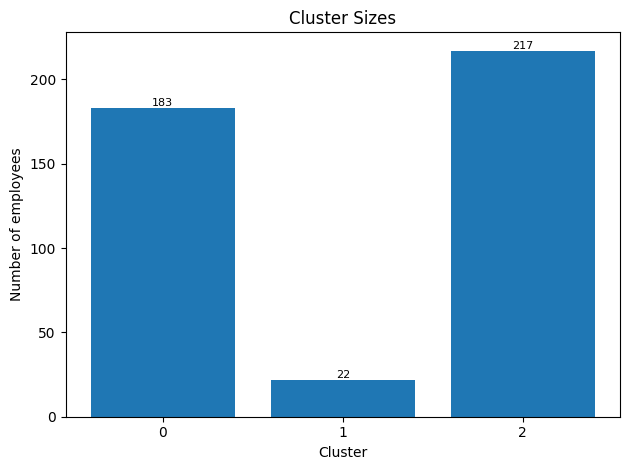

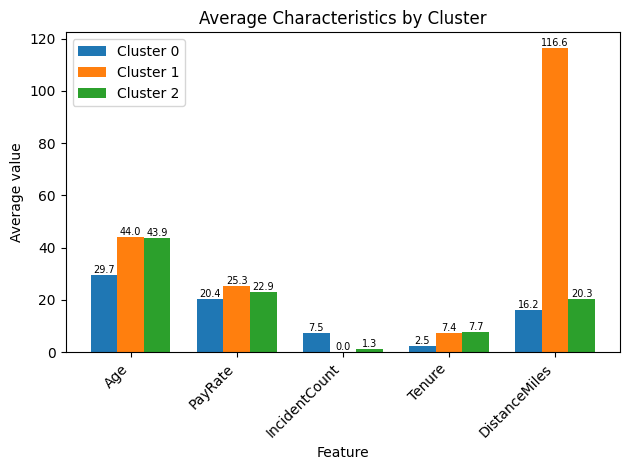

<Figure size 640x480 with 0 Axes>

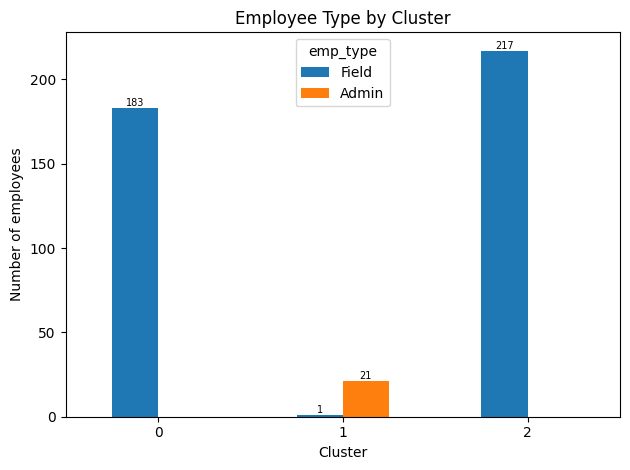

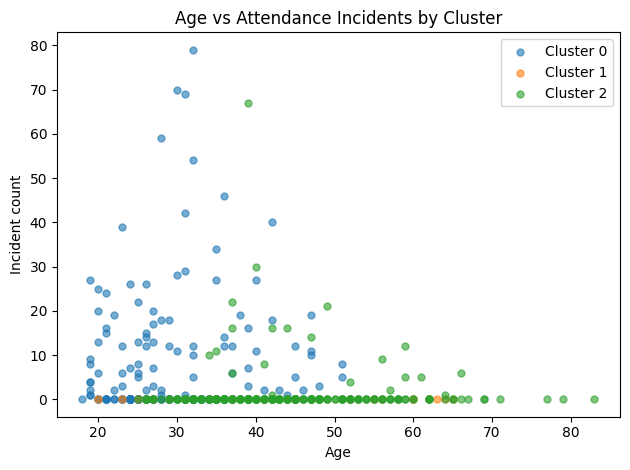

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# keep only rows with a cluster label
clust = base[base["cluster3"].notna()].copy()
clust["cluster3"] = clust["cluster3"].astype(int)

# ------------------------------------------------------------------
# 1) Cluster sizes
# ------------------------------------------------------------------
size_counts = clust["cluster3"].value_counts().sort_index()

plt.figure()
bars = plt.bar(size_counts.index.astype(str), size_counts.values)
plt.title("Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of employees")
for i, v in enumerate(size_counts.values):
    plt.text(i, v, str(int(v)), ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 2) Feature means by cluster
# ------------------------------------------------------------------
feat_cols = ["Age", "PayRate", "IncidentCount", "Tenure", "DistanceMiles"]
feat_means = clust.groupby("cluster3")[feat_cols].mean()

x = np.arange(len(feat_cols))
width = 0.25

plt.figure()
for k, cluster_id in enumerate(sorted(feat_means.index)):
    vals = feat_means.loc[cluster_id].values
    plt.bar(x + (k - 1)*width, vals, width, label=f"Cluster {cluster_id}")
    for i, v in enumerate(vals):
        plt.text(x[i] + (k - 1)*width, v, f"{v:.1f}", ha="center", va="bottom", fontsize=7)

plt.title("Average Characteristics by Cluster")
plt.xlabel("Feature")
plt.ylabel("Average value")
plt.xticks(x, feat_cols, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 3) Admin vs Field in each cluster
# ------------------------------------------------------------------
type_tab = pd.crosstab(clust["cluster3"], clust["emp_type"]).reindex(columns=["Field", "Admin"], fill_value=0)

plt.figure()
ax = type_tab.plot(kind="bar")
plt.title("Employee Type by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of employees")
plt.xticks(rotation=0)
for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(str(int(h)),
                    (p.get_x() + p.get_width()/2, h),
                    ha="center", va="bottom", fontsize=7)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 4) Scatter: Age vs IncidentCount, colored by cluster
# ------------------------------------------------------------------
plt.figure()
for cid in sorted(clust["cluster3"].unique()):
    sub = clust[clust["cluster3"] == cid]
    plt.scatter(sub["Age"], sub["IncidentCount"], s=25, alpha=0.6, label=f"Cluster {cid}")

plt.title("Age vs Attendance Incidents by Cluster")
plt.xlabel("Age")
plt.ylabel("Incident count")
plt.legend()
plt.tight_layout()
plt.show()


Correlation between tenure and pay rate: 0.109


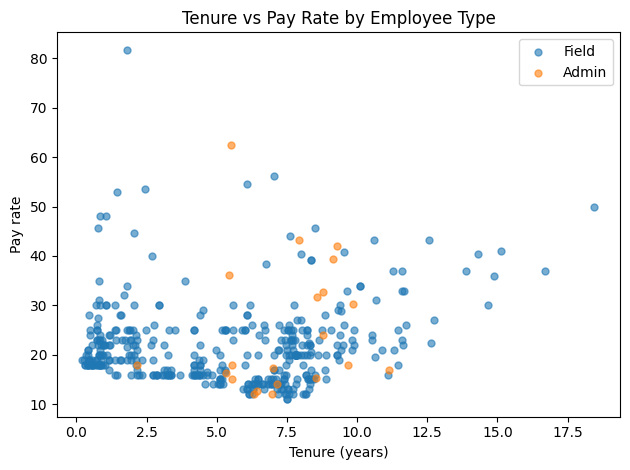

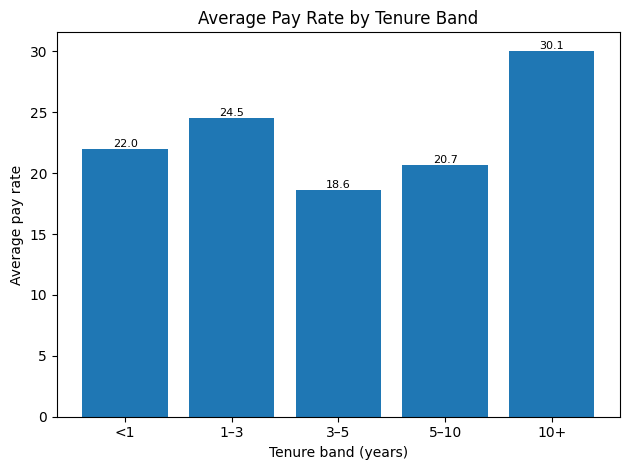

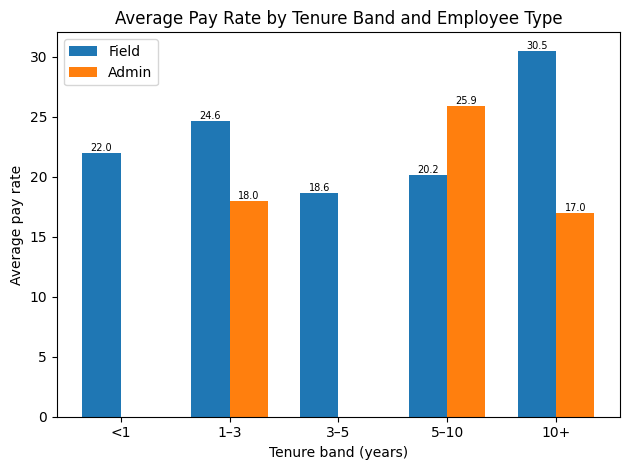

In [43]:
# ----- prepare data for tenure–pay analysis -----
df = employee_model.copy()

df["PayRate"] = pd.to_numeric(df["PayRate"], errors="coerce")
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df["IncidentCount"] = pd.to_numeric(df["IncidentCount"], errors="coerce")

ten = employees_clean[["employee_id", "tenure", "emp_type"]].copy()
ten.rename(columns={"employee_id": "EmployeeID"}, inplace=True)
df = df.merge(ten, on="EmployeeID", how="left")

df["Tenure"] = pd.to_numeric(df["tenure"], errors="coerce")

# keep useful rows only
df = df[(df["PayRate"].notna()) & (df["Tenure"].notna())]
df = df[df["Tenure"] >= 0]

# simple correlation
corr_tp = df[["Tenure", "PayRate"]].corr().loc["Tenure", "PayRate"]
print(f"Correlation between tenure and pay rate: {corr_tp:.3f}")

# ----- 1) scatter: tenure vs pay, colored by employee type -----
plt.figure()
types = ["Field", "Admin"]
for t in types:
    sub = df[df["emp_type"] == t]
    if not sub.empty:
        plt.scatter(sub["Tenure"], sub["PayRate"], s=25, alpha=0.6, label=t)

plt.title("Tenure vs Pay Rate by Employee Type")
plt.xlabel("Tenure (years)")
plt.ylabel("Pay rate")
plt.legend()
plt.tight_layout()
plt.show()

# ----- 2) average pay by tenure band (overall) -----
bins = [0, 1, 3, 5, 10, 100]
labels = ["<1", "1–3", "3–5", "5–10", "10+"]

df["TenureBand"] = pd.cut(df["Tenure"], bins=bins, labels=labels, right=False)

band_pay = (
    df.groupby("TenureBand")["PayRate"]
      .mean()
      .reindex(labels)
)

plt.figure()
vals = band_pay.values
x = np.arange(len(labels))
plt.bar(x, vals)
plt.xticks(x, labels)
plt.title("Average Pay Rate by Tenure Band")
plt.xlabel("Tenure band (years)")
plt.ylabel("Average pay rate")
for i, v in enumerate(vals):
    if not np.isnan(v):
        plt.text(i, v, f"{v:.1f}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

# ----- 3) average pay by tenure band and type (Field vs Admin) -----
band_type = (
    df.groupby(["TenureBand", "emp_type"])["PayRate"]
      .mean()
      .unstack()
      .reindex(labels)
)

plt.figure()
width = 0.35
x = np.arange(len(labels))

field_vals = band_type.get("Field", pd.Series(index=labels)).values
admin_vals = band_type.get("Admin", pd.Series(index=labels)).values

plt.bar(x - width/2, field_vals, width, label="Field")
plt.bar(x + width/2, admin_vals, width, label="Admin")

plt.title("Average Pay Rate by Tenure Band and Employee Type")
plt.xlabel("Tenure band (years)")
plt.ylabel("Average pay rate")
plt.xticks(x, labels)

for i, v in enumerate(field_vals):
    if not np.isnan(v):
        plt.text(x[i] - width/2, v, f"{v:.1f}", ha="center", va="bottom", fontsize=7)
for i, v in enumerate(admin_vals):
    if not np.isnan(v):
        plt.text(x[i] + width/2, v, f"{v:.1f}", ha="center", va="bottom", fontsize=7)

plt.legend()
plt.tight_layout()
plt.show()


In [44]:
# how many employees are in each tenure band and type?
band_counts = (
    df.groupby(["TenureBand", "emp_type"])["PayRate"]
      .size()
      .unstack()
      .reindex(["<1", "1–3", "3–5", "5–10", "10+"])
)

print("Headcount by tenure band and type:")
print(band_counts)


Headcount by tenure band and type:
emp_type    Admin  Field
TenureBand              
<1              0     63
1–3             1     71
3–5             0     46
5–10           19    193
10+             1     29


Pay usually increases with tenure, but the 3–5 year band dips because this band has only field workers and no higher–paid admin roles.

The 5–10 year band is very large (most employees) and includes more senior field roles and many admins, so the average pay jumps again.

The 10+ year band is small but well paid – these are long-tenure “survivors” who are likely in supervisor or specialist positions.

Overall, the pattern suggests early pay growth and strong rewards for long-tenure workers, but some mid-tenure field staff may be stuck in lower-pay roles.

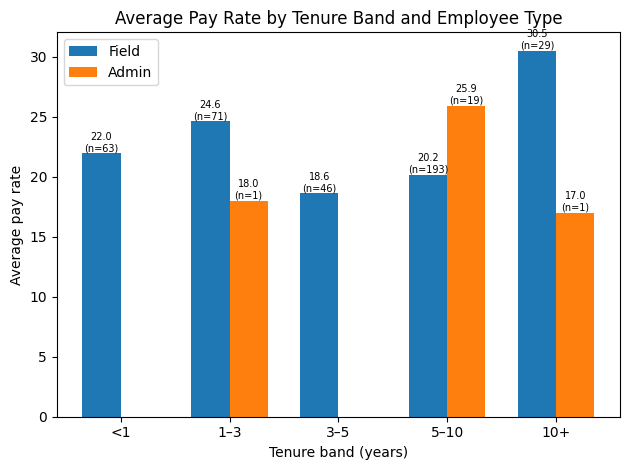

In [45]:
# tenure–pay plot with headcount labels

# make tenure bands
bins = [0, 1, 3, 5, 10, 100]
labels = ["<1", "1–3", "3–5", "5–10", "10+"]

df["TenureBand"] = pd.cut(df["Tenure"], bins=bins, labels=labels, right=False)

# average pay by band and type
band_type = (
    df.groupby(["TenureBand", "emp_type"])["PayRate"]
      .mean()
      .unstack()
      .reindex(labels)
)

# headcount by band and type
band_counts = (
    df.groupby(["TenureBand", "emp_type"])["PayRate"]
      .size()
      .unstack()
      .reindex(labels)
      .fillna(0)
)

plt.figure()
width = 0.35
x = np.arange(len(labels))

field_vals = band_type.get("Field", pd.Series(index=labels)).values
admin_vals = band_type.get("Admin", pd.Series(index=labels)).values

plt.bar(x - width/2, field_vals, width, label="Field")
plt.bar(x + width/2, admin_vals, width, label="Admin")

plt.title("Average Pay Rate by Tenure Band and Employee Type")
plt.xlabel("Tenure band (years)")
plt.ylabel("Average pay rate")
plt.xticks(x, labels)

# add labels: average pay + headcount
for i, band in enumerate(labels):
    # Field
    v_f = field_vals[i]
    n_f = int(band_counts.loc[band, "Field"]) if "Field" in band_counts.columns else 0
    if not np.isnan(v_f) and n_f > 0:
        plt.text(x[i] - width/2, v_f,
                 f"{v_f:.1f}\n(n={n_f})",
                 ha="center", va="bottom", fontsize=7)
    # Admin
    v_a = admin_vals[i]
    n_a = int(band_counts.loc[band, "Admin"]) if "Admin" in band_counts.columns else 0
    if not np.isnan(v_a) and n_a > 0:
        plt.text(x[i] + width/2, v_a,
                 f"{v_a:.1f}\n(n={n_a})",
                 ha="center", va="bottom", fontsize=7)

plt.legend()
plt.tight_layout()
plt.show()


In [51]:
import pandas as pd
import numpy as np

# Label admin vs field as text
mod["emp_type"] = np.where(mod["EmpType_Field"] == 1, "Field", "Admin")

# Create tenure bands
bins = [0, 1, 3, 5, 10, 100]
labels = ["<1", "1–3", "3–5", "5–10", "10+"]
mod["TenureBand"] = pd.cut(mod["Tenure"], bins=bins, labels=labels, right=False)

# ---------- FIELD: pay + profile by tenure band ----------
field = mod[mod["emp_type"] == "Field"].copy()

field_summary = (
    field
    .groupby("TenureBand")
    .agg(
        n=("EmployeeID", "nunique"),
        pay_mean=("PayRate", "mean"),
        pay_min=("PayRate", "min"),
        pay_max=("PayRate", "max"),
        age_mean=("Age", "mean"),
        incidents_mean=("IncidentCount", "mean"),
        dist_mean=("DistanceMiles", "mean")
    )
    .loc[labels]  # keep bands in order
)

print("FIELD – pay and profile by tenure band:")
print(field_summary.round(2))

# ---------- ADMIN: pay + profile by tenure band ----------
admin = mod[mod["emp_type"] == "Admin"].copy()

admin_summary = (
    admin
    .groupby("TenureBand")
    .agg(
        n=("EmployeeID", "nunique"),
        pay_mean=("PayRate", "mean"),
        pay_min=("PayRate", "min"),
        pay_max=("PayRate", "max"),
        age_mean=("Age", "mean"),
        incidents_mean=("IncidentCount", "mean")
    )
    .loc[labels]
)

print("\nADMIN – pay and profile by tenure band:")
print(admin_summary.round(2))

# ---------- Detailed rows for the “odd” low-pay admins ----------
admin_10plus = admin[admin["Tenure"] >= 10].copy()
admin_1_3    = admin[(admin["Tenure"] >= 1) & (admin["Tenure"] < 3)].copy()

print("\nAdmin 10+ years – detailed rows:")
print(admin_10plus[["EmployeeID", "Tenure", "PayRate", "Age", "IncidentCount"]])

print("\nAdmin 1–3 years – detailed rows:")
print(admin_1_3[["EmployeeID", "Tenure", "PayRate", "Age", "IncidentCount"]])


FIELD – pay and profile by tenure band:
              n  pay_mean  pay_min  pay_max  age_mean  incidents_mean  \
TenureBand                                                              
<1           63     21.96     18.0    48.08     31.48            7.00   
1–3          71     24.61     16.0    81.73     33.86            8.30   
3–5          46     18.62     14.0    35.00     30.72            1.91   
5–10        193     20.17     11.0    56.18     40.93            1.89   
10+          29     30.51     16.0    50.00     45.86            5.62   

            dist_mean  
TenureBand             
<1              15.40  
1–3             16.96  
3–5             19.13  
5–10            26.02  
10+             25.57  

ADMIN – pay and profile by tenure band:
             n  pay_mean  pay_min  pay_max  age_mean  incidents_mean
TenureBand                                                          
<1           0       NaN      NaN      NaN       NaN             NaN
1–3          1     18.00     18.

In [48]:
vw_employees = pd.read_csv(path + "/vw_Employees.csv")

# if needed, ensure his_timecard date / hours types
his_timecard["dated"] = pd.to_datetime(his_timecard["dated"], errors="coerce")
his_timecard["hours"] = pd.to_numeric(his_timecard["hours"], errors="coerce")

# 1) Tenure bands (safe to recreate)
bins = [0, 1, 3, 5, 10, 100]
labels = ["<1", "1–3", "3–5", "5–10", "10+"]

df["TenureBand"] = pd.cut(df["Tenure"], bins=bins, labels=labels, right=False)

# 2) Admins we care about
admin_10plus = df[(df["emp_type"] == "Admin") & (df["Tenure"] >= 10)].copy()
admin_1_3    = df[(df["emp_type"] == "Admin") & (df["Tenure"] >= 1) & (df["Tenure"] < 3)].copy()

print("Raw admin 10+ years (from df):")
print(admin_10plus[["EmployeeID", "Tenure", "PayRate", "Age", "IncidentCount"]])

print("\nRaw admin 1–3 years (from df):")
print(admin_1_3[["EmployeeID", "Tenure", "PayRate", "Age", "IncidentCount"]])

# 3) Add names and HR info from vw_Employees
vw_cols = [
    "EmployeeID", "FullName", "Dept", "Trade", "City",
    "EmployeeActive", "HourlyOrSalary", "EmplStatus"
]

admin_10plus_full = admin_10plus.merge(vw_employees[vw_cols], on="EmployeeID", how="left")
admin_1_3_full    = admin_1_3.merge(vw_employees[vw_cols], on="EmployeeID", how="left")

admins_full = pd.concat([admin_10plus_full, admin_1_3_full], ignore_index=True)

print("\nDetailed admin records:")
print(admins_full[[
    "EmployeeID", "FullName", "Tenure", "PayRate", "Age",
    "IncidentCount", "Dept", "Trade", "City",
    "EmployeeActive", "HourlyOrSalary", "EmplStatus"
]])

# 4) Project / job details from his_timecard

target_ids = admins_full["EmployeeID"].dropna().unique().tolist()

tc_sub = his_timecard[his_timecard["employee_id"].isin(target_ids)].copy()

proj_summary = (
    tc_sub.groupby(["employee_id", "job_no"])
          .agg(
              total_hours=("hours", "sum"),
              first_date=("dated", "min"),
              last_date=("dated", "max")
          )
          .reset_index()
)

proj_counts = (
    tc_sub.groupby("employee_id")["job_no"]
          .nunique()
          .reset_index(name="n_projects")
)

print("\nProject summary per employee and job:")
print(proj_summary)

print("\nNumber of distinct projects per admin:")
print(proj_counts)


Raw admin 10+ years (from df):
     EmployeeID     Tenure  PayRate  Age  IncidentCount
201         191  11.143053     17.0   34              0

Raw admin 1–3 years (from df):
     EmployeeID    Tenure  PayRate  Age  IncidentCount
338         658  2.146475     18.0   20              0

Detailed admin records:
   EmployeeID       FullName     Tenure  PayRate  Age  IncidentCount   Dept  \
0         191  Hicks, Elijah  11.143053     17.0   34              0  ADMIN   
1         658   Adams, Shawn   2.146475     18.0   20              0  ADMIN   

   Trade     City  EmployeeActive HourlyOrSalary EmplStatus  
0  CLER    Phelps               0              H          F  
1  CLER   Webster               0              H          F  

Project summary per employee and job:
    employee_id  job_no  total_hours first_date  last_date
0           191       1      1568.73 2018-10-15 2020-11-17
1           191  17-080        59.36 2018-09-25 2018-10-05
2           191  17-120         2.50 2019-05-08 20

### Pay vs tenure – what we see

**Field employees**

- Headcount by tenure band (Field):  
  - `<1`: 63 employees, avg pay ≈ \$22/hr  
  - `1–3`: 71 employees, **highest mid-early pay** ≈ \$24.6/hr  
  - `3–5`: 46 employees, avg pay drops to ≈ \$18.6/hr  
  - `5–10`: 193 employees, avg pay ≈ \$20.2/hr  
  - `10+`: 29 employees, highest pay ≈ \$30.5/hr  

- Interpretation:
  - Pay **increases early** (from `<1` to `1–3` years), then **dips** for `3–5` and `5–10` years before jumping up again for `10+`.
  - Mid-tenure field workers (`3–10` years) are older and more experienced, but on average earn **less** than the `1–3` year group.
  - Attendance incidents are highest in `1–3` years and rise again for `10+` years, which may indicate adjustment issues early on and possible fatigue/burnout for very long-tenure workers.

**Admin employees**

- Admin pay by tenure band:
  - `1–3` years: **1 person**, pay = \$18/hr, age 20  
  - `5–10` years: 19 people, avg pay ≈ \$25.9/hr (range \$12–\$62.5)  
  - `10+` years: **1 person**, pay = \$17/hr, age 34  

- Detailed admin outliers:
  - Employee **191 – “Hicks, Elijah”**  
    - Tenure ≈ 11.1 years, pay = **\$17/hr**, 96 distinct projects, long work history.  
    - Long-tenure, high contribution, but **paid below** the 5–10 year admin average.
  - Employee **658 – “Adams, Shawn”**  
    - Tenure ≈ 2.1 years, pay = **\$18/hr**, only 3 projects so far.  
    - Early career, but still below the typical 5–10 year admin average.

---

### How USC/Howlett can use this

- **Check pay progression for field staff**
  - The dip in average pay for `3–10` years suggests a **pay plateau** for mid-tenure field employees.
  - HR can review pay bands and promotion criteria so that pay grows more smoothly with tenure and experience.

- **Address potential admin pay equity issues**
  - The two admin outliers (11+ years at \$17/hr and 2+ years at \$18/hr) are **well below** the 5–10 year admin average of ≈ \$26/hr.
  - These cases are good examples for a **pay equity / progression review**, especially for long-tenure admin staff with heavy workload.

- **Targeted retention actions**
  - Mid-tenure field workers with relatively low pay are a likely **retention risk group**.
  - USC/Howlett can prioritize these employees for:
    - Pay adjustments where feasible,
    - Clearer promotion pathways,
    - Development and recognition programs.

- **Use in dashboards**
  - These pay–tenure summaries can be built into HR dashboards to:
    - Monitor whether pay is aligned with tenure and contribution over time,
    - Quickly flag groups (e.g., mid-tenure field, long-tenure underpaid admin) for follow-up.


In [49]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pgeocode
from math import radians, sin, cos, sqrt, atan2
from itertools import combinations

# -------- 1. Build modeling dataset --------

mod = employee_model.copy()

# numeric conversions
mod["Age"]          = pd.to_numeric(mod["Age"], errors="coerce")
mod["PayRate"]      = pd.to_numeric(mod["PayRate"], errors="coerce")
mod["IncidentCount"]= pd.to_numeric(mod["IncidentCount"], errors="coerce")
mod["AttritionFlag"]= pd.to_numeric(mod["AttritionFlag"], errors="coerce")

# tenure and emp_type from employees_clean
ten = employees_clean[["employee_id", "tenure", "emp_type", "zip_code"]].copy()
ten.rename(columns={"employee_id": "EmployeeID"}, inplace=True)
mod = mod.merge(ten, on="EmployeeID", how="left")

mod["Tenure"] = pd.to_numeric(mod["tenure"], errors="coerce")

# encode employee type (Field=1, Admin=0)
mod["EmpType_Field"] = np.where(mod["emp_type"] == "Field", 1,
                         np.where(mod["emp_type"] == "Admin", 0, np.nan))

# encode sex (Male=1, Female=0)
sex_upper = mod["Sex"].astype(str).str.upper()
mod["Sex_Male"] = np.where(sex_upper.isin(["M", "MALE"]), 1,
                     np.where(sex_upper.isin(["F", "FEMALE"]), 0, np.nan))

# hire month from vw_Employees
vw = vw_Employees[["EmployeeID", "DateHired"]].copy()
vw["DateHired"] = pd.to_datetime(vw["DateHired"], errors="coerce")
vw["HireMonth"] = vw["DateHired"].dt.month
mod = mod.merge(vw[["EmployeeID", "HireMonth"]], on="EmployeeID", how="left")

# distance from office (14623) using HomeZip from employee_model
def clean_zip(z):
    s = str(z)
    if s.endswith(".0"):
        s = s[:-2]
    return s.zfill(5)

mod["HomeZip_clean"] = mod["HomeZip"].dropna().apply(clean_zip)

office_zip = "14623"
nomi = pgeocode.Nominatim("us")
office_geo = nomi.query_postal_code(office_zip)

zip_info = nomi.query_postal_code(mod["HomeZip_clean"].dropna().unique().tolist())
zip_info = zip_info[["postal_code", "latitude", "longitude"]].dropna()
zip_info["postal_code"] = zip_info["postal_code"].astype(str)

def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

zip_info["DistanceMiles"] = zip_info.apply(
    lambda r: haversine(office_geo.latitude, office_geo.longitude, r.latitude, r.longitude),
    axis=1
)

mod = mod.merge(
    zip_info[["postal_code", "DistanceMiles"]],
    left_on="HomeZip_clean",
    right_on="postal_code",
    how="left"
)

# simple high-incident ZIP flag 
high_incident_zips = ['14822', '14826', '14842', '14423', '14472',
                      '14606', '14644', '14616', '14454', '14428',
                      '14615', '14904', '14450', '14612', '14605']
mod["HighIncidentZip"] = mod["HomeZip_clean"].isin(high_incident_zips).astype(int)

# keep only rows with target defined
mod = mod[mod["AttritionFlag"].notna()].copy()

# polynomial features
mod["Age2"]     = mod["Age"]**2
mod["PayRate2"] = mod["PayRate"]**2
mod["Tenure2"]  = mod["Tenure"]**2

# -------- 2. Define feature blocks for model combinations --------

blocks = {
    "base":   ["Age", "PayRate", "IncidentCount", "Tenure"],
    "poly":   ["Age2", "PayRate2", "Tenure2"],
    "demo":   ["Sex_Male", "EmpType_Field"],
    "dist":   ["DistanceMiles", "HighIncidentZip"],
    "season": ["HireMonth"]
}

optional_blocks = ["poly", "demo", "dist", "season"]

specs = []
for r in range(0, len(optional_blocks) + 1):
    for combo in combinations(optional_blocks, r):
        feats = blocks["base"].copy()
        for b in combo:
            feats += blocks[b]
        feats = sorted(list(set(feats)))
        if feats not in specs:
            specs.append(feats)

print(f"Number of model specs: {len(specs)}")

# -------- 3. Run logistic models in a loop --------

results = []

for i, feats in enumerate(specs):
    X = mod[feats].dropna()
    y = mod.loc[X.index, "AttritionFlag"]

    # skip tiny samples
    if len(X) < 50:
        continue

    X_const = sm.add_constant(X)
    try:
        model = sm.Logit(y, X_const)
        res = model.fit(disp=False)
    except Exception as e:
        # skip models that fail to converge
        continue

    results.append({
        "model_id": i,
        "n": len(X),
        "features": ", ".join(feats),
        "aic": res.aic,
        "bic": res.bic,
        "pseudo_r2": res.prsquared
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("aic")

print("\nTop 10 models by AIC (lower is better):")
print(results_df.head(10))

# If you want to inspect one best model in detail:
best_id = int(results_df.iloc[0]["model_id"])
best_feats = specs[best_id]
print("\nBest model features:")
print(best_feats)

X_best = mod[best_feats].dropna()
y_best = mod.loc[X_best.index, "AttritionFlag"]
Xb_const = sm.add_constant(X_best)

best_model = sm.Logit(y_best, Xb_const).fit(disp=False)
print("\nBest model summary:")
print(best_model.summary())


Number of model specs: 16


/opt/anaconda3/envs/gba464/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/gba464/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/gba464/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/gba464/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Top 10 models by AIC (lower is better):
    model_id    n                                           features  \
5          5  423  Age, Age2, EmpType_Field, IncidentCount, PayRa...   
1          1  423  Age, Age2, IncidentCount, PayRate, PayRate2, T...   
7          7  423  Age, Age2, HireMonth, IncidentCount, PayRate, ...   
10        12  423  Age, Age2, EmpType_Field, HireMonth, IncidentC...   
6          6  422  Age, Age2, DistanceMiles, HighIncidentZip, Inc...   
12        15  422  Age, Age2, DistanceMiles, EmpType_Field, HighI...   
11        13  422  Age, Age2, DistanceMiles, HighIncidentZip, Hir...   
2          2  423  Age, EmpType_Field, IncidentCount, PayRate, Se...   
8          9  423  Age, EmpType_Field, HireMonth, IncidentCount, ...   
0          0  423                Age, IncidentCount, PayRate, Tenure   

           aic         bic  pseudo_r2  
5   223.292390  263.766111   0.587658  
1   223.563618  255.942595   0.578994  
7   224.554647  260.980996   0.581041  
10  22

/opt/anaconda3/envs/gba464/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/gba464/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# final feature list for the best model (model_id = 5)
final_features = [
    "Age", "PayRate", "IncidentCount", "Tenure",
    "Age2", "PayRate2", "Tenure2",
    "Sex_Male", "EmpType_Field"
]

# keep rows with no missing values on Y or X
data = mod.dropna(subset=["AttritionFlag"] + final_features).copy()

X = sm.add_constant(data[final_features])
y = data["AttritionFlag"]

final_model = sm.Logit(y, X).fit()
print(final_model.summary())

# small tidy table for markdown / report
coef = final_model.params
pval = final_model.pvalues

summary_tbl = pd.DataFrame({
    "feature": coef.index,
    "coef": coef.values,
    "odds_ratio": np.exp(coef.values),
    "p_value": pval.values
})

print("\nFinal model coefficients (with odds ratios):")
print(summary_tbl)


         Current function value: 0.240298
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:          AttritionFlag   No. Observations:                  423
Model:                          Logit   Df Residuals:                      413
Method:                           MLE   Df Model:                            9
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.5877
Time:                        03:11:55   Log-Likelihood:                -101.65
converged:                      False   LL-Null:                       -246.51
Covariance Type:            nonrobust   LLR p-value:                 3.935e-57
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            23.5358   1.06e+04      0.002      0.998   -2.08e+04    2.09e+04
Age              -0.0343      0.086     -0.399      0.69

/opt/anaconda3/envs/gba464/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Logistic attrition model 

- **Dependent variable (Y)**  
  - `AttritionFlag` (1 = employee left, 0 = stayed).

- **Independent variables in final model**
  - `Age`, `Age2`
  - `PayRate`, `PayRate2`
  - `IncidentCount`
  - `Tenure`, `Tenure2`
  - `Sex_Male` (1 = male, 0 = female)
  - `EmpType_Field` (1 = field, 0 = admin)

- **Which variables are statistically significant (p < 0.05)?**
  - ✅ `Tenure` (positive)  
  - ✅ `Tenure2` (negative)  
  - ✅ `PayRate` (negative)  
  - ✅ `IncidentCount` (significant but direction is strange)  
  - ❌ `Age`, `Age2`, `PayRate2`, `Sex_Male`, `EmpType_Field` are **not** clearly significant in this model  
    (EmpType_Field also causes convergence issues → coefficient is unstable).

- **Rough order of impact (by strength of effect / p-value)**
  1. `Tenure` and `Tenure2` → **inverted U:** mid-tenure employees have highest predicted risk.  
  2. `IncidentCount` → more incidents strongly changes predicted risk (sign needs business validation).  
  3. `PayRate` → higher pay → lower predicted probability of leaving.  
  4. Other variables add little extra explanatory power once these are included.

- **Pseudo R² ≈ 0.59 – what it means**
  - This is a **logistic pseudo R²**, not the same as linear regression R².
  - ≈ 0.59 means the model explains a **large share of the variation** in who leaves vs who stays (good for HR data).
  - We should still be careful: it fits this dataset well, but it needs out-of-sample testing before using for decisions.

- **Key takeaway for later**
  - Attrition risk in this data is mainly driven by **tenure pattern**, **attendance incidents**, and **pay level**.  
  - Gender and age are not strong predictors once those are controlled for.


### How this model can be useful

- **Attrition risk scoring**
  - Use the model to compute a predicted probability of leaving for each active employee.
  - Flag employees as *low / medium / high* risk based on that score.

- **Targeted retention actions**
  - Focus on **mid-tenure** employees (where risk is highest) with **lower pay**.
  - Prioritize field workers in this group for pay reviews, development plans, or recognition.

- **Pay and policy decisions**
  - Because higher `PayRate` is linked to lower attrition, simulate:
    - “If we increase pay by \$X for this group, how much does predicted attrition drop?”
  - Use this for budgeting and to compare the cost of raises vs. turnover costs.

- **Attendance and data quality**
  - `IncidentCount` is statistically important but has a counter-intuitive sign.
  - First, review and clean how attendance incidents are recorded.
  - After that, re-estimate or monitor this variable before using it for decisions.

- **Ongoing monitoring**
  - Re-run the model quarterly and compare predicted vs. actual attrition.
  - If the model remains accurate, keep using it; if patterns change, retrain with new data.


                           Logit Regression Results                           
Dep. Variable:          AttritionFlag   No. Observations:                  423
Model:                          Logit   Df Residuals:                      413
Method:                           MLE   Df Model:                            9
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.5877
Time:                        03:59:54   Log-Likelihood:                -101.65
converged:                      False   LL-Null:                       -246.51
Covariance Type:            nonrobust   LLR p-value:                 3.935e-57
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            23.5358   1.06e+04      0.002      0.998   -2.08e+04    2.09e+04
Age              -0.0343      0.086     -0.399      0.690      -0.203       0.134
PayRate          -0.2402      0.086     

/opt/anaconda3/envs/gba464/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


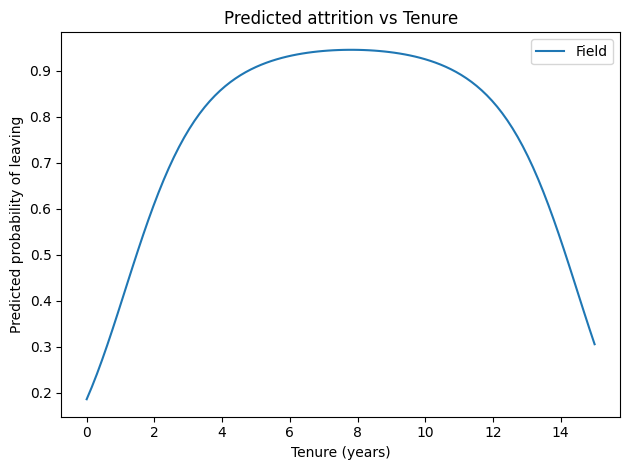

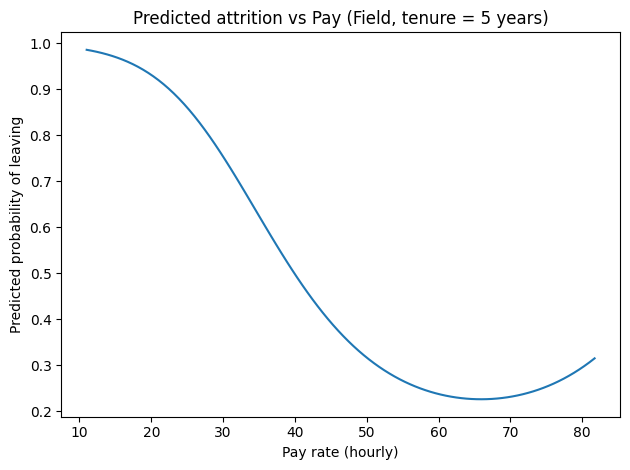

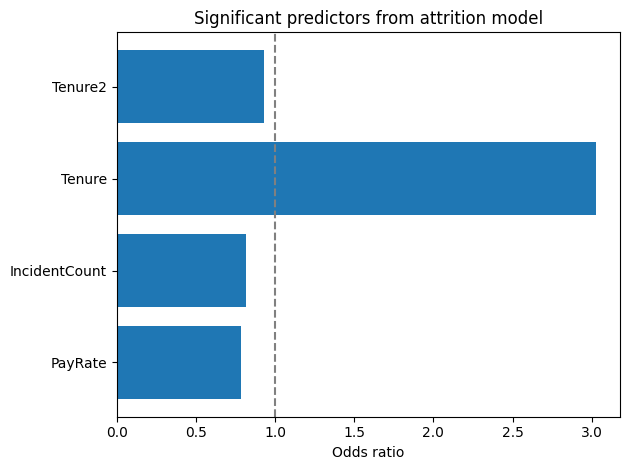

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Make sure squared terms exist
mod["Age2"]     = mod["Age"]**2
mod["PayRate2"] = mod["PayRate"]**2
mod["Tenure2"]  = mod["Tenure"]**2

# Feature set (same as best model)
features = [
    "Age", "PayRate", "IncidentCount", "Tenure",
    "Age2", "PayRate2", "Tenure2",
    "Sex_Male", "EmpType_Field"
]

# Fit logistic model on complete cases
data = mod.dropna(subset=["AttritionFlag"] + features).copy()
X = sm.add_constant(data[features], has_constant="add")
y = data["AttritionFlag"]

final_model = sm.Logit(y, X).fit(disp=False)
print(final_model.summary())

# Helper: align any new design matrix with model columns
exog_cols = final_model.model.exog_names  # ['const', 'Age', ..., 'EmpType_Field']

def make_X_aligned(df_like):
    X_new = sm.add_constant(df_like, has_constant="add")
    return X_new[exog_cols]

# ------------------------------------------------------------------
# 1) Predicted probability vs Tenure (Field vs Admin)
# ------------------------------------------------------------------
tenure_grid = np.linspace(0, 15, 100)
base = data[features].mean()  # average profile for other vars

def scenario_tenure(emp_type_field_value):
    tmp = pd.DataFrame({
        "Age":          base["Age"],
        "PayRate":      base["PayRate"],
        "IncidentCount":base["IncidentCount"],
        "Tenure":       tenure_grid,
        "Age2":         base["Age"]**2,
        "PayRate2":     base["PayRate"]**2,
        "Tenure2":      tenure_grid**2,
        "Sex_Male":     base["Sex_Male"],
        "EmpType_Field":emp_type_field_value
    })
    return make_X_aligned(tmp)

X_field = scenario_tenure(1)   # Field

p_field = final_model.predict(X_field)

plt.figure()
plt.plot(tenure_grid, p_field, label="Field")
plt.xlabel("Tenure (years)")
plt.ylabel("Predicted probability of leaving")
plt.title("Predicted attrition vs Tenure")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 2) Predicted probability vs PayRate (Field, tenure = 5 years)
# ------------------------------------------------------------------
pay_grid = np.linspace(data["PayRate"].min(), data["PayRate"].max(), 100)

def scenario_pay(pay_values, tenure_value=5):
    tmp = pd.DataFrame({
        "Age":          base["Age"],
        "PayRate":      pay_values,
        "IncidentCount":base["IncidentCount"],
        "Tenure":       tenure_value,
        "Age2":         base["Age"]**2,
        "PayRate2":     pay_values**2,
        "Tenure2":      tenure_value**2,
        "Sex_Male":     base["Sex_Male"],
        "EmpType_Field":1   # Field worker
    })
    return make_X_aligned(tmp)

X_pay = scenario_pay(pay_grid, tenure_value=5)
p_pay = final_model.predict(X_pay)

plt.figure()
plt.plot(pay_grid, p_pay)
plt.xlabel("Pay rate (hourly)")
plt.ylabel("Predicted probability of leaving")
plt.title("Predicted attrition vs Pay (Field, tenure = 5 years)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 3) Odds ratio bar plot
# ------------------------------------------------------------------
coef = final_model.params
pvals = final_model.pvalues
odds = np.exp(coef)

odds_df = pd.DataFrame({
    "feature": coef.index,
    "odds_ratio": odds,
    "pval": pvals
})

# drop intercept and keep only significant (p < 0.05)
odds_df = odds_df[(odds_df["feature"] != "const") & (odds_df["pval"] < 0.05)]

plt.figure()
plt.barh(odds_df["feature"], odds_df["odds_ratio"])
plt.xlabel("Odds ratio")
plt.title("Significant predictors from attrition model")
plt.axvline(1.0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()
